<a href="https://colab.research.google.com/github/ciouyu/generative_ai/blob/main/final/final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install openai
!pip install gradio

In [ ]:
!pip install diffusers transformers accelerate safetensors huggingface_hub --upgrade


#LLM

In [ ]:
title = "chatbot"

In [ ]:
description = "test"

In [ ]:
import os
from google.colab import userdata
#【使用 Groq】
api_key = userdata.get('Groq')
base_url="https://api.groq.com/openai/v1"
os.environ['OPENAI_API_KEY']=api_key
provider = "groq"
model = "llama-3.3-70b-versatile"

In [ ]:
system = '''你是一個家庭廚師，專門給人進行食譜建議。也就是有人問你三個食材種類，你就幫他設計個食譜。
每個人問你都只需要照提問的三個食材提供食譜，
如果有人提出食材以外的東西叫你幫忙設計食譜請你直接說"我拒絕回答"。
如果不是提出三個食材請你無情地叫他提供三樣食材。
將每個人問的問題視為獨立回答。
請你先將你要做什麼料理，什麼風格先列出來，
再將各食材份量，以及步驟詳細列出。
最後請以  關鍵字:食材內容，料理，風格。的形式列出一個關鍵字list
請以台灣習慣的中文設計食譜。'''
#此為限制最後可以輸出到其他模型的格式

#diffusion

In [ ]:
from diffusers import StableDiffusionPipeline, UniPCMultistepScheduler
import torch
import gc
import matplotlib.pyplot as plt

In [ ]:
model_name = "mvrdock/sd1.4-food"

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    use_safetensors=True
).to("cuda")
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [ ]:
def generate_images(prompt, use_enhance, enhance_text, use_negative, negative_text,
                    use_custom_seed, custom_seed, height, width, steps, num_images):

    height = int(height)
    width = int(width)

    if height % 8 != 0 or width % 8 != 0:
        raise ValueError("高度和寬度必須是8的倍數！")

    if use_custom_seed:
        base_seed = int(custom_seed)
    else:
        base_seed = random.randint(0, 2**32 - 1)

    seeds = [base_seed + i for i in range(num_images)]

    prompts = ["deleciouse food","nohuman","food"]
    negative_prompts = ["human"]
    generators = []

    final_prompt = prompt
    if use_enhance and enhance_text:
        final_prompt = prompt + ", " + enhance_text

    final_negative = negative_text if use_negative else None

    for seed in seeds:
        g = torch.Generator("cuda").manual_seed(seed)
        generators.append(g)
        prompts.append(final_prompt)
        negative_prompts.append(final_negative)

    gc.collect()
    torch.cuda.empty_cache()

    images = []
    for i in range(num_images):
        with torch.no_grad():
            image = pipe(
                prompt=prompts[i],
                negative_prompt=negative_prompts[i] if final_negative else None,
                height=height,
                width=width,
                num_inference_steps=steps,
                guidance_scale=7.5,
                generator=generators[i]
            ).images[0]
            images.append(image)

    return images, f"使用的 random seeds: {seeds}"

#gradio

In [ ]:
import gradio as gr
import re
import random
from PIL import Image

# 模擬語言模型回應（請換成你自己的變數與 client）
def mychatbot(prompt):
    messages = [{"role": "system", "content": system},
                {"role": "user", "content": prompt}]
    chat_completion = client.chat.completions.create(
        messages=messages,
        model=model,
    )
    reply = chat_completion.choices[0].message.content
    return reply

# 提取「關鍵字」欄位
def extract_keywords_from_reply(reply):
    match = re.search(r"[＊*]{0,2}關鍵字[：:][＊*]{0,2}\s*(.+)", reply, re.IGNORECASE | re.DOTALL)
    if match:
        return match.group(1).strip()
    return "❌ 沒有找到關鍵字。"

# 生成圖像（使用你已經設定好的 diffusion pipeline）
def generate_image_from_prompt(prompt):
    image = pipe(prompt, height=512, width=512, num_inference_steps=30).images[0]
    return image

# 介面設定
with gr.Blocks() as demo:
    gr.Markdown("#食譜生成器")

    prompt_input = gr.Textbox(label="輸入三個食材")
    reply_output = gr.Textbox(label="AI 回應", lines=10)
    keyword_output = gr.Textbox(label="提取的關鍵字")
    image_output = gr.Image(label="生成圖像", type="pil")

    with gr.Row():
        submit_btn = gr.Button("送出給 LLaMA")
        extract_btn = gr.Button("提取關鍵字")
        generate_btn = gr.Button("使用關鍵字生成圖片")

    submit_btn.click(fn=mychatbot,
                     inputs=prompt_input,
                     outputs=reply_output)

    extract_btn.click(fn=extract_keywords_from_reply,
                      inputs=reply_output,
                      outputs=keyword_output)

    generate_btn.click(fn=generate_image_from_prompt,
                       inputs=keyword_output,
                       outputs=image_output)

demo.launch()


#成品

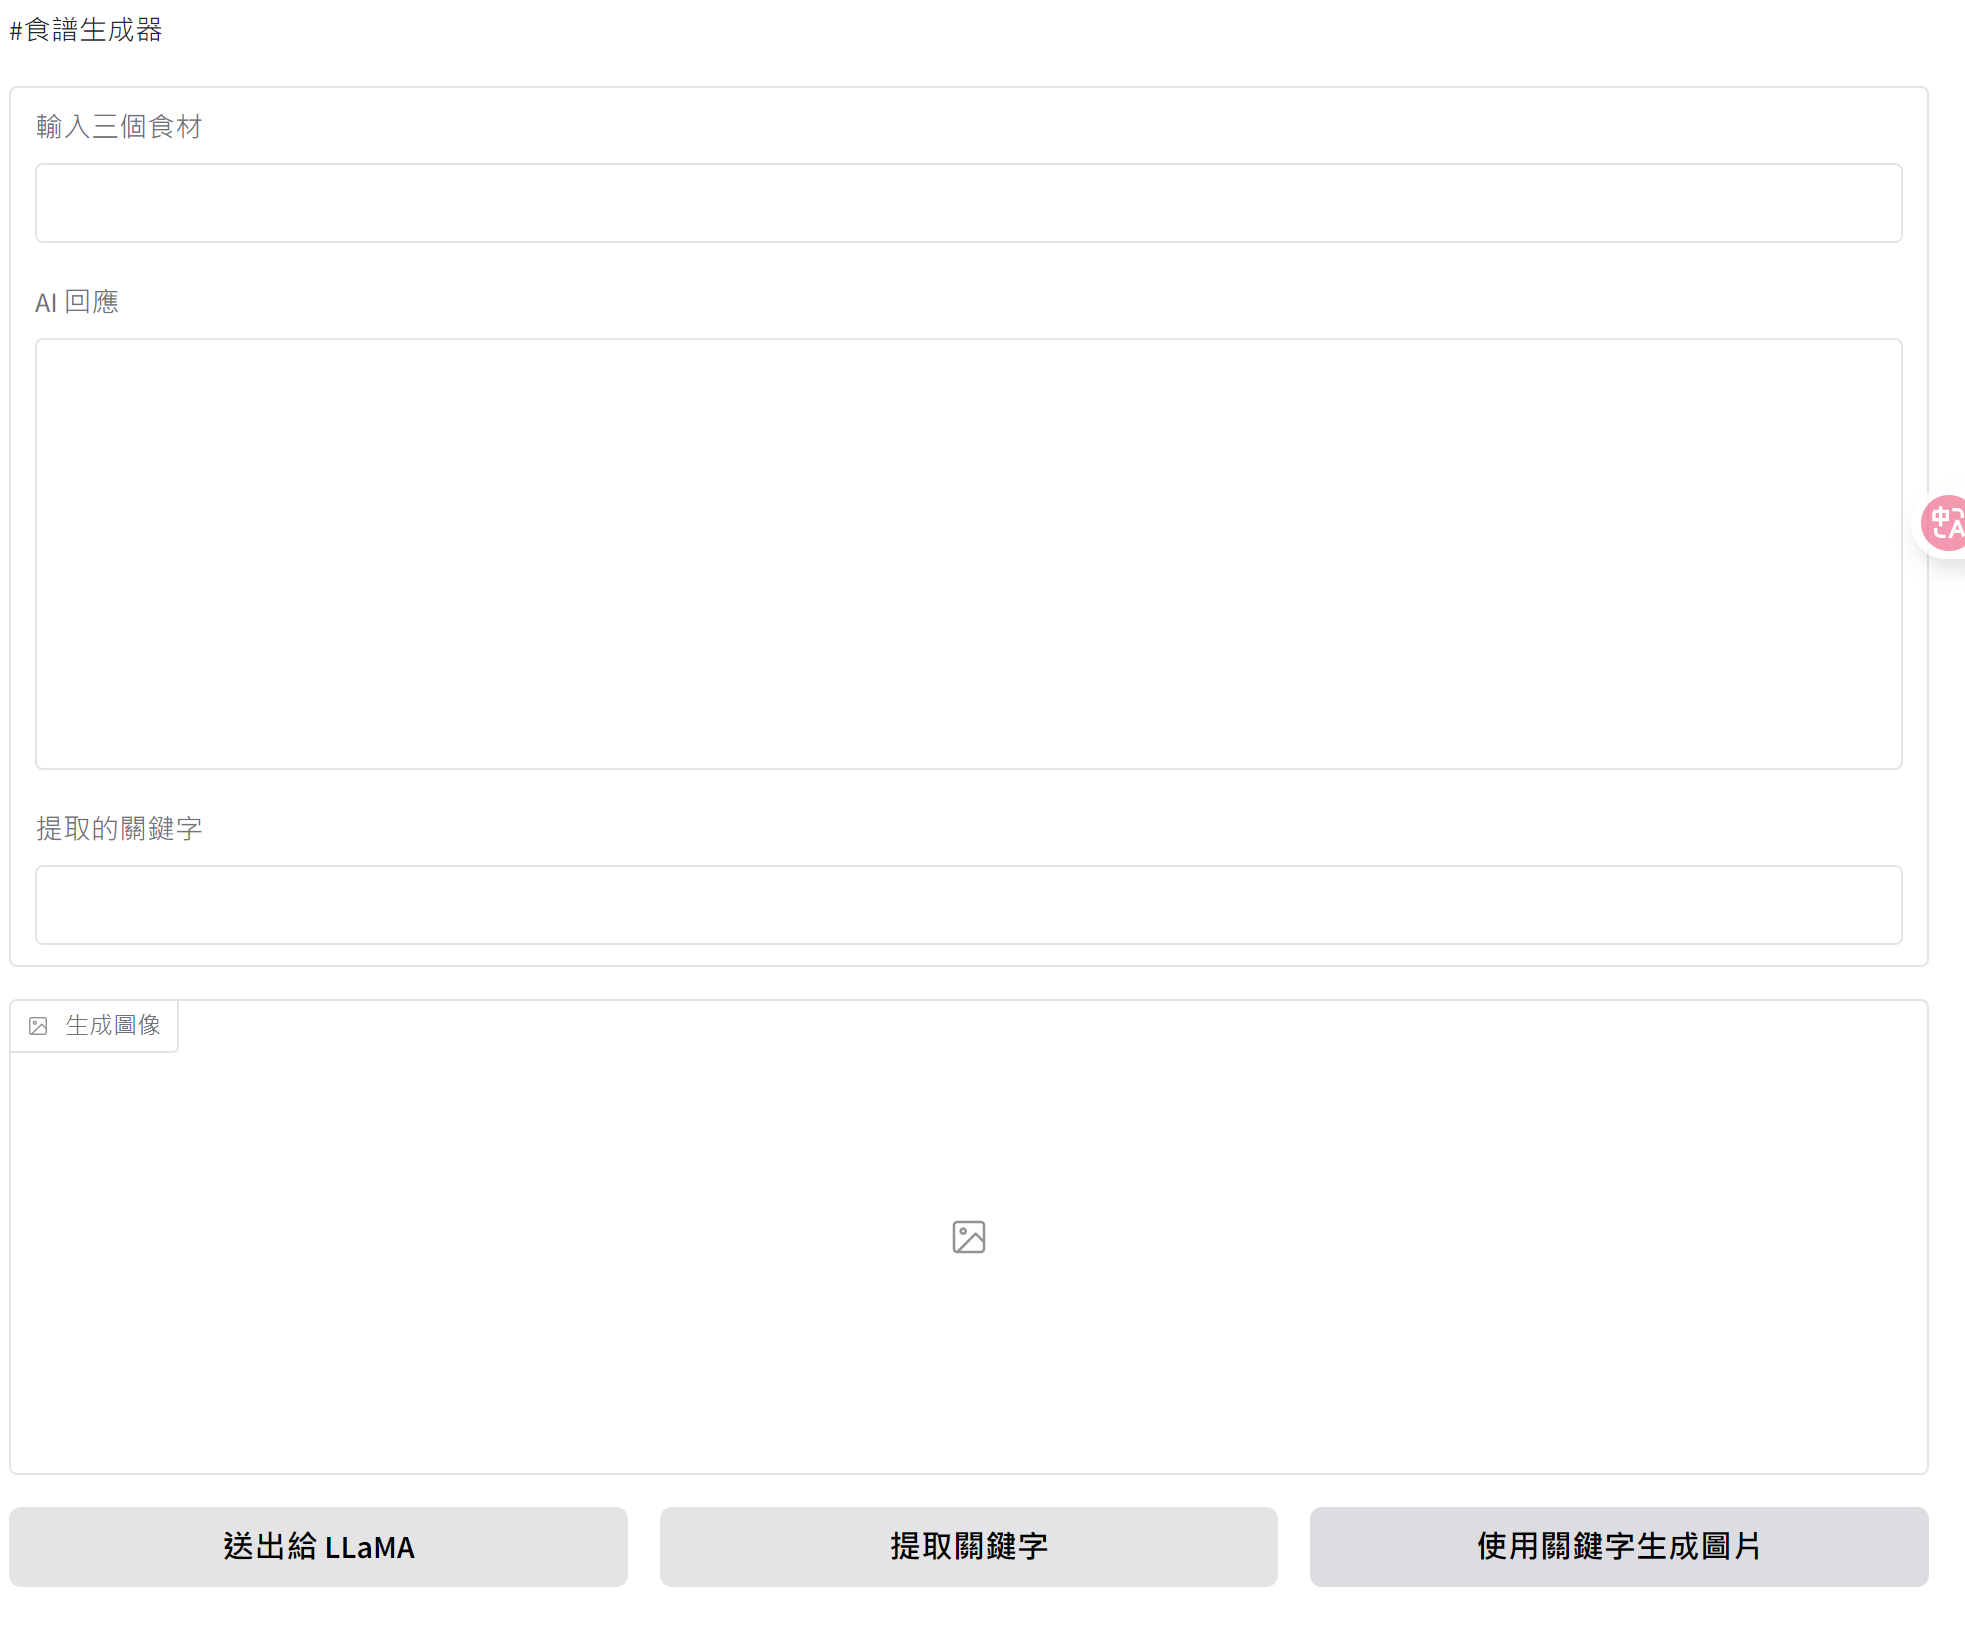

前面沒問題

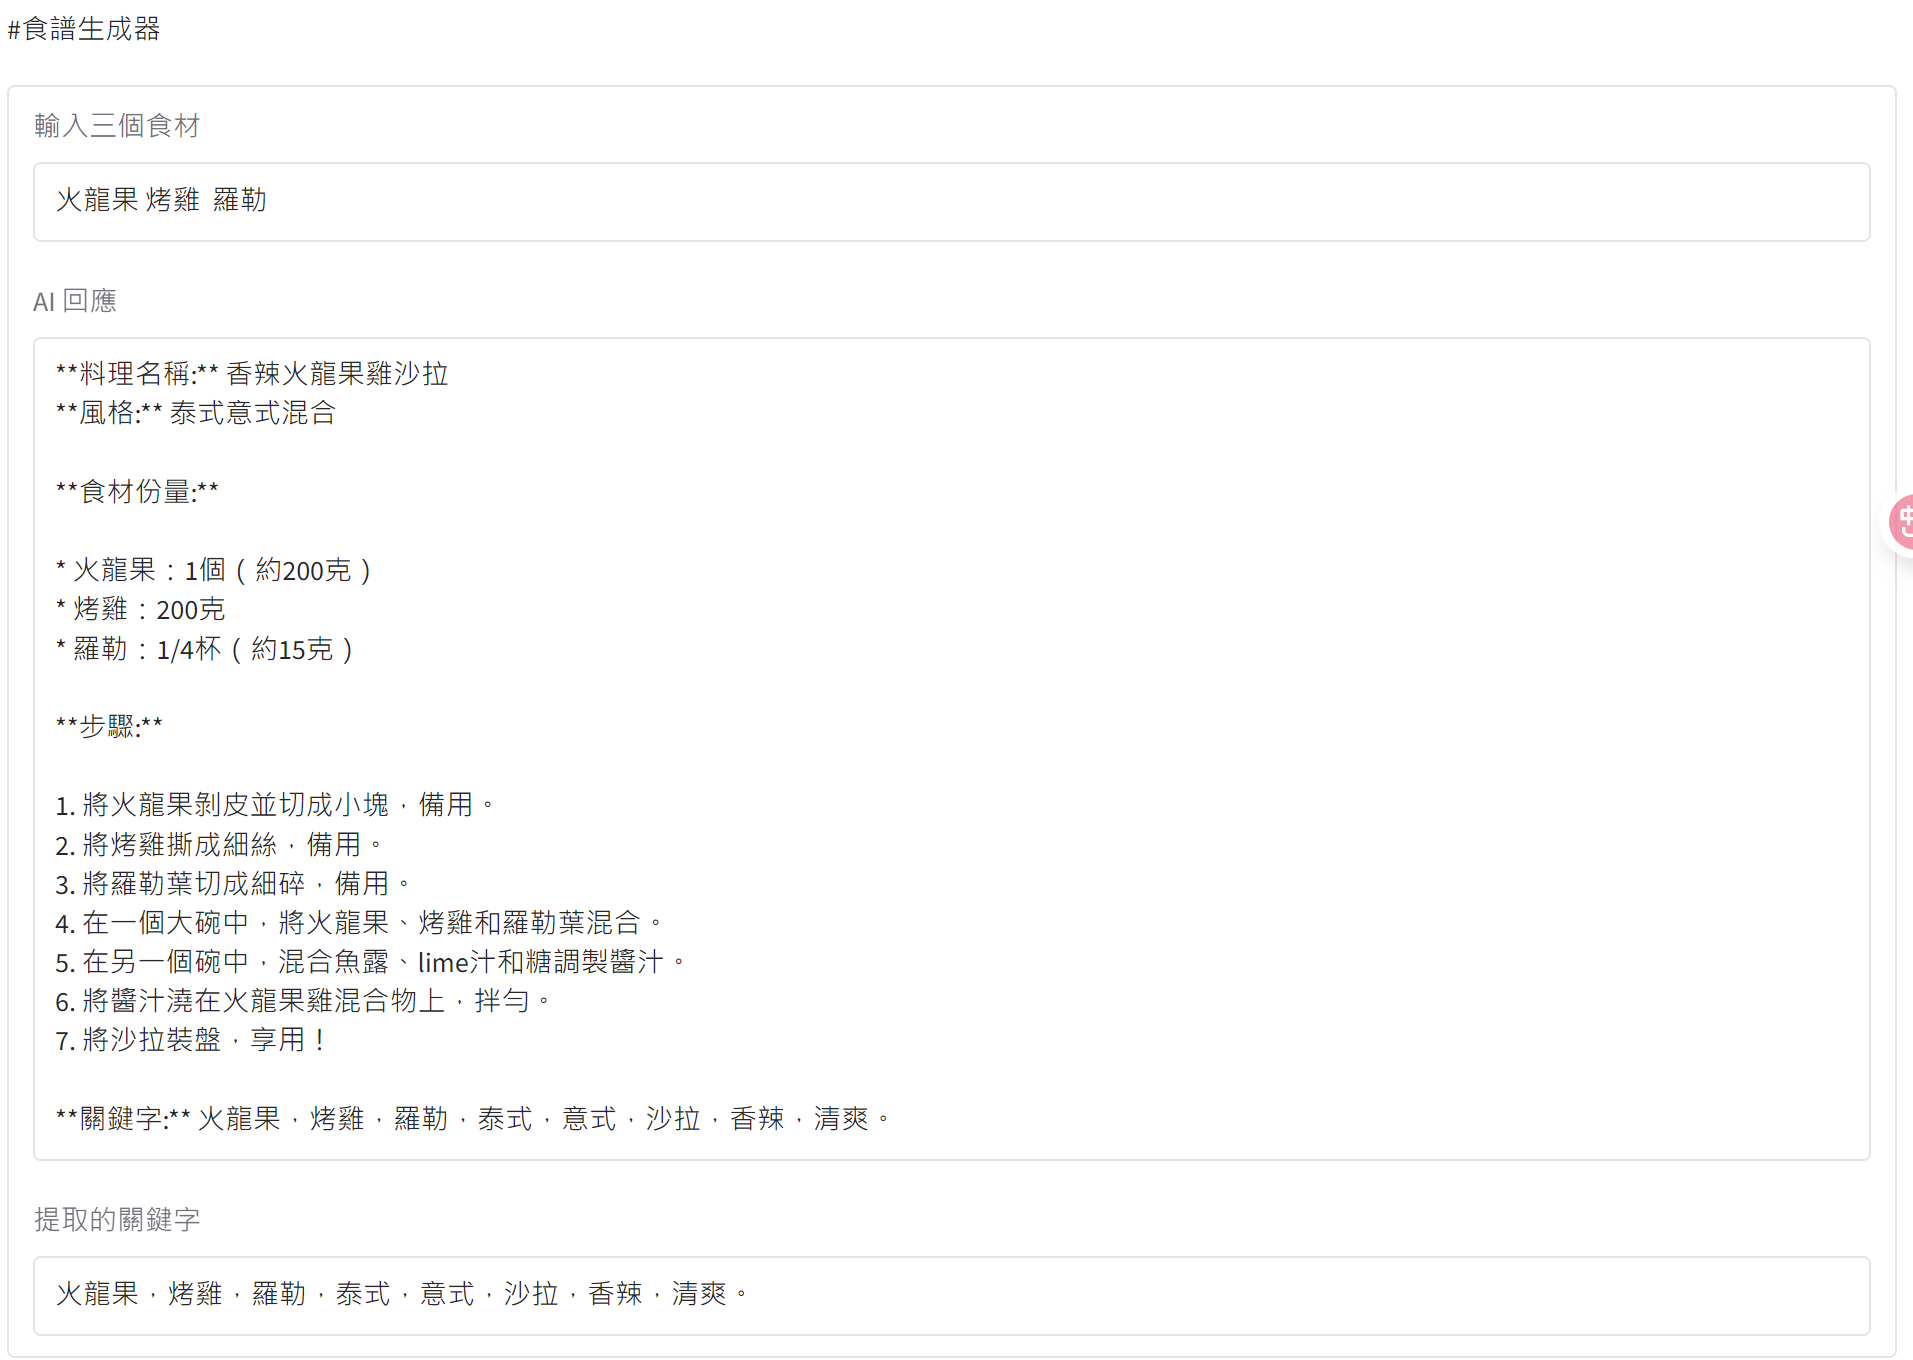

但可能我找的模型有問題 或許sd1.4-food不是專門生食物的   
但確實成功將生圖及食譜生成串起來

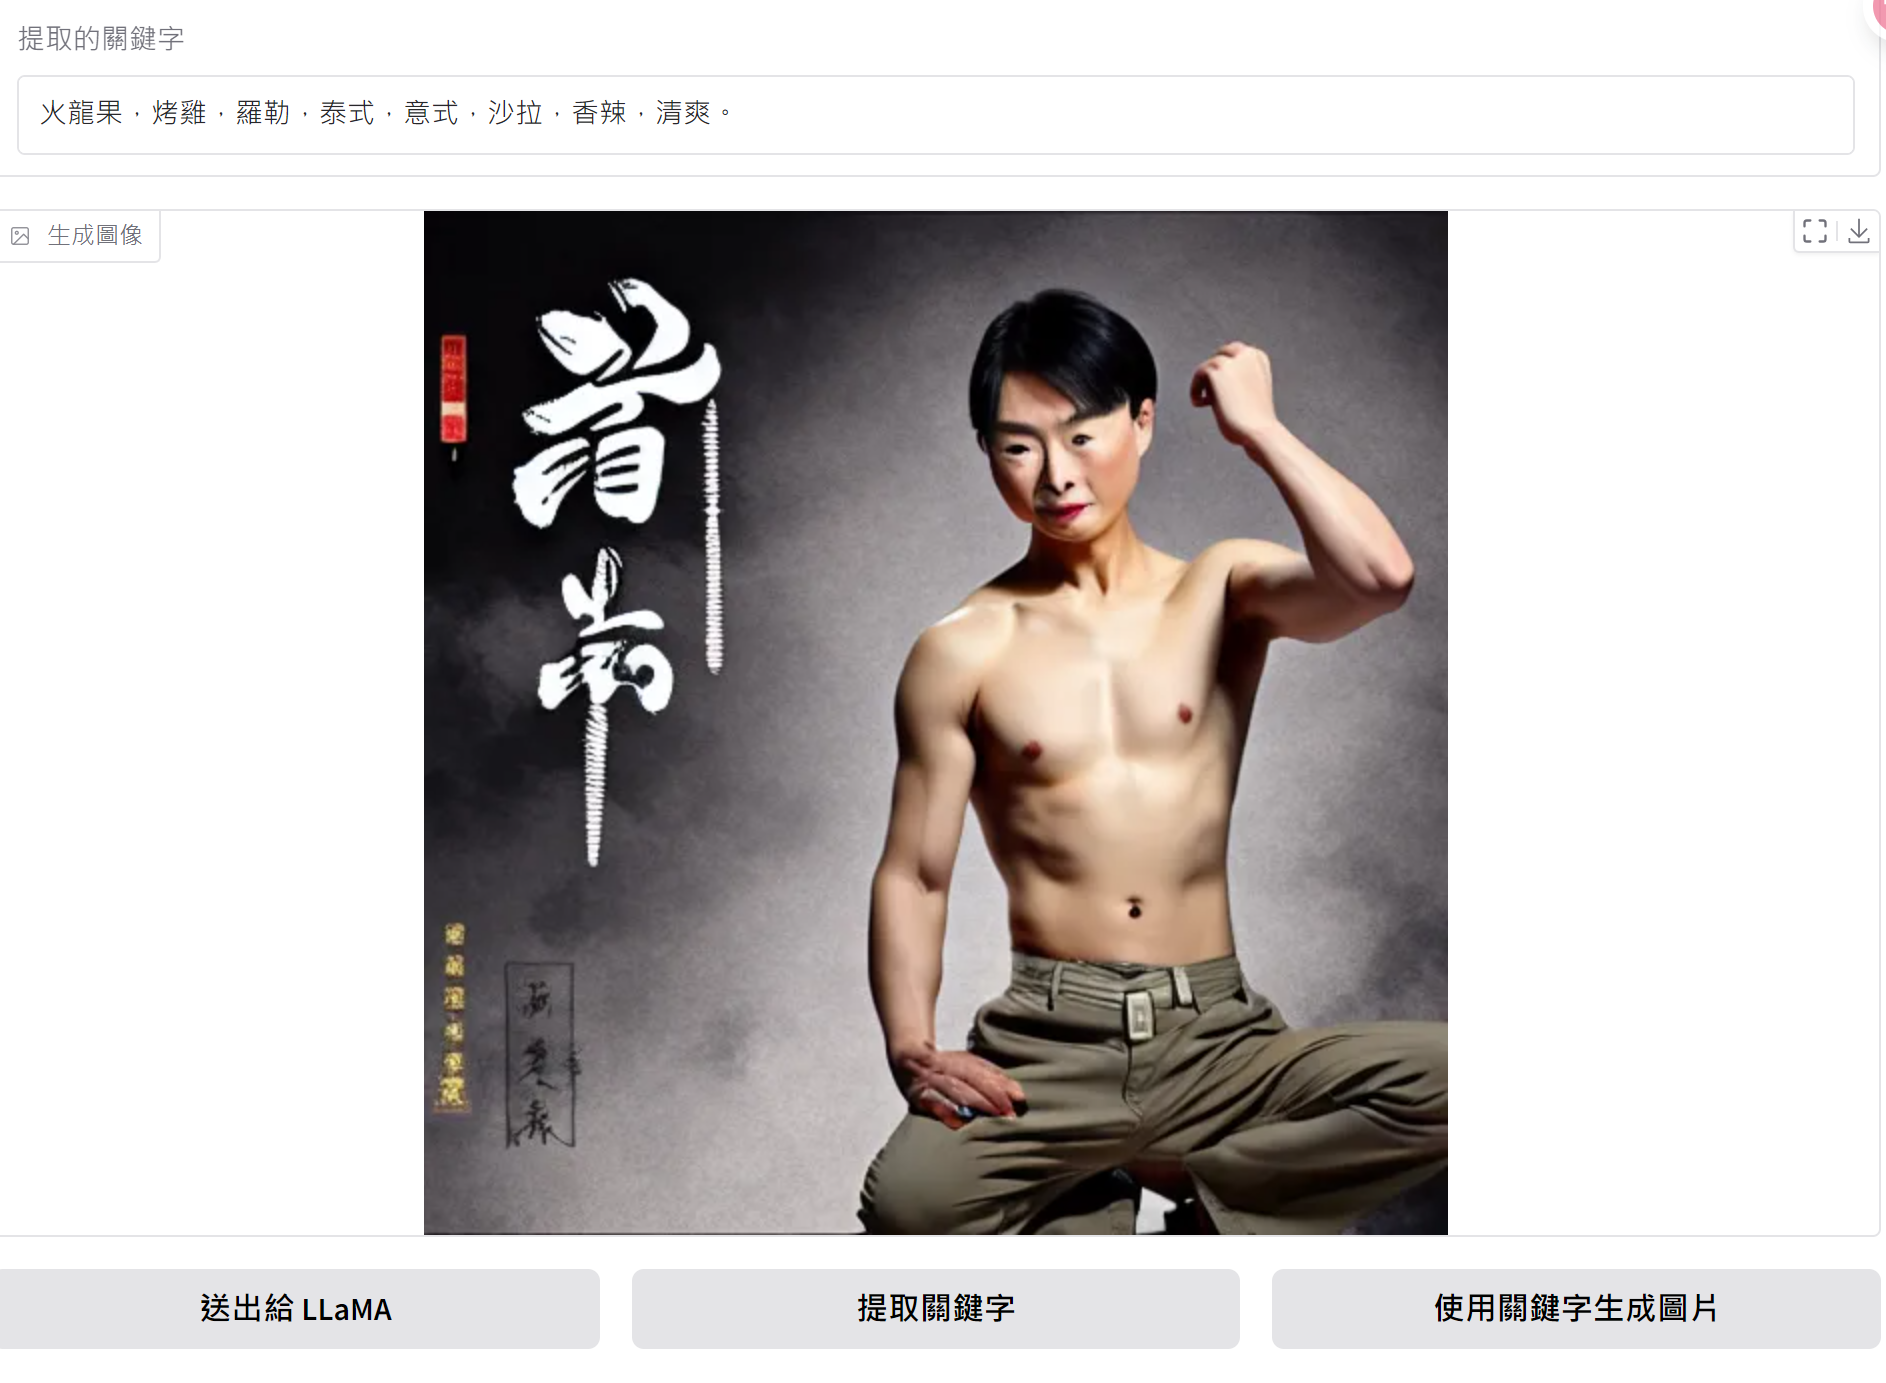

欸不是欸 你誰    
我都在prompt裡面偷偷下"deleciouse food","nohuman","food"了欸